# SQUID

## initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks
import scienceplots
plt.figure()
# plt.style.reload_library()
plt.style.use('science')

<Figure size 640x480 with 0 Axes>

In [2]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Diode Calibration

### Load data

In [3]:
room_temp = pd.read_csv('SQUID/data/V-I/roomtemp.csv')
liquid_nitrogen = pd.read_csv('SQUID/data/V-I/crittemp.csv')
room_temp

,0_x,0_y
0,0.985322,33.925200
1,1.749933,102.407787
2,4.553510,172.417867
3,6.337605,239.627543
4,8.121699,307.855548
...,...,...
495,60.625049,1062.182331
496,61.134790,1062.182331
497,63.938367,1062.182331
498,65.467591,1062.182331


### analysis

1.6325167650794552
R_N = 3.265(10) Ohm


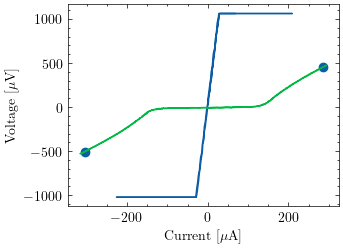

In [4]:
plt.plot(room_temp['0_x'], room_temp['0_y'], label='room temp')
plt.plot(liquid_nitrogen['0_x'], liquid_nitrogen['0_y'], label='liquid nitrogen')
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')
dx = [liquid_nitrogen['0_x'][350],liquid_nitrogen['0_x'][120]]
dy = [liquid_nitrogen['0_y'][350],liquid_nitrogen['0_y'][120]]
plt.scatter(dx,dy)
normal_slope =(dy[1]- dy[0]) / (dx[1]- dx[0])
print(normal_slope)
R_N = un.ufloat(normal_slope*2, 0.01)
print(f"R_N = {R_N:S} Ohm")

242.3+/-2.6
5.623+/-0.028
width= 0.2423 \pm 0.0026 mA
I_crit= 60.6 \pm 0.6 uA


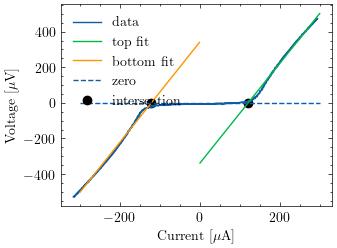

In [5]:
mi,ma = 60, 165
x,y = liquid_nitrogen['0_x'], liquid_nitrogen['0_y']
plt.plot(x, y ,label='data')

xl = np.linspace(-300,300,500)
half = int(len(xl)/2)

# plt.plot(x[mi:ma], y[mi:ma] ,label='top data')
c, cov = curve_fit(lambda x, a, b: a*x + b, x[mi:ma], y[mi:ma])
perr = np.sqrt(np.diag(cov))
x0= - un.ufloat(c[1],perr[1])/un.ufloat(c[0],perr[0]) 
slope_top = un.ufloat(c[0],perr[0]) 

plt.plot(xl[half:], c[0]*xl[half:] + c[1], label='top fit',lw=1)

mi,ma = 280, 410
# plt.plot(x[mi:ma], y[mi:ma] ,label='bottom data')
c, cov = curve_fit(lambda x, a, b: a*x + b, x[mi:ma], y[mi:ma])
perr = np.sqrt(np.diag(cov))

plt.plot(xl[:half], c[0]*xl[:half] + c[1], label='bottom fit',lw=1)
width = x0 + un.ufloat(c[1],perr[1])/un.ufloat(c[0],perr[0])
print(width)

plt.hlines(0,-300,300,linestyles='dashed',label='zero')

plt.scatter([x0.n,-c[1]/c[0]],[0,0],c='k',label='intersection')

res_n = (slope_top + un.ufloat(c[0],perr[0]) )
print(res_n)
plt.legend()
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

plt.savefig('SQUID/output/2-critical-current.pdf')

print(f"width= {width*1e-3:L} mA")
# critical_current = width /4 * 1e-6
print(f"I_crit= {width /4:L} uA")

69     166.683090
119    289.658168
169    157.348453
290   -161.462846
350   -311.167482
406   -157.990234
Name: 0_x, dtype: float64
width= 0.322 \pm 0.008 mA
I_crit= 80.4 \pm 2.0 uA


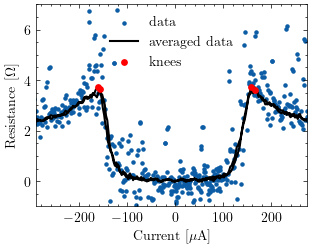

In [6]:
w = 8
x,y = liquid_nitrogen['0_x'].rolling(window=w).mean(), liquid_nitrogen['0_y'].rolling(window=w).mean()
plt.scatter(liquid_nitrogen['0_x'], np.gradient(liquid_nitrogen['0_y'], liquid_nitrogen['0_x']), s=5,label='data')

plt.plot(x, np.gradient(y, x), label='averaged data',lw=1.5,c='k')

plt.ylim(-1,7)
plt.xlim(-290,275)



peaks, _ = find_peaks(np.gradient(y, x),prominence=0.5)
plt.scatter(x[peaks], np.gradient(y, x)[peaks], c='r',s=15, label='knees',zorder=10)

# normal_resistance = 

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Resistance [$\Omega$]')
plt.legend()

print(x[peaks])

xr,xl=0,0
for i in x[peaks]:
    if 0 < i < 200:
        xr += i
    if -200 < i < 0:
        xl += i
xr /= 2
xl /= 2

width = un.ufloat(xr - xl,8)
print(f"width= {width*1e-3:L} mA")
critical_current = width /4 * 1e-6
print(f"I_crit= {critical_current*1e6:L} uA")

# plt.savefig('SQUID/output/2-critical-current.pdf')

x_o pos = 0.14 \pm 0.05 mA
x_o neg = -0.14 \pm 0.05 mA
width= 0.28 \pm 0.07 mA
I_crit= 69+/-18 uA


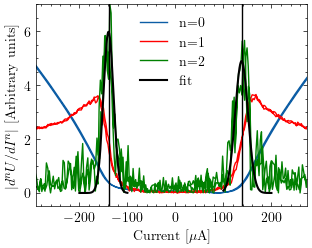

In [7]:
w = 10
x,y = liquid_nitrogen['0_x'].rolling(window=w).mean(), liquid_nitrogen['0_y'].rolling(window=w).mean()
plt.plot(x,np.fabs(y/100),label='n=0')
plt.plot(x, np.fabs(np.gradient(y,x)),label='n=1',c='r')
dy2=np.gradient(np.gradient(y,x),x)*50
plt.plot(x,  np.fabs(dy2) ,label='n=2',c='g')

def gauss(x, x0, a, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

xl = np.linspace(100,200,500)

c, cov = curve_fit(gauss, x[2*w:200], dy2[2*w:200], p0=[150, 6 ,20])
perr = np.sqrt(np.diag(cov))
plt.plot(xl, gauss(xl, *c), label='fit',c='k',lw=1.5,zorder=10)
x_0r = un.ufloat(c[0],50)
print(f"x_o pos = {x_0r*1e-3:L} mA")

c, cov = curve_fit(gauss, x[300:-2*w], dy2[300:-2*w], p0=[-150, 6 ,20])
perr = np.sqrt(np.diag(cov))
plt.plot(-xl,- gauss(-xl, *c),c='k',lw=1.5,zorder=10)
x_0l = un.ufloat(c[0],50)
print(f"x_o neg = {x_0l*1e-3:L} mA")

plt.ylim(-0.5,7)

plt.xlim(-290,275)

width = x_0r - x_0l
print(f"width= {width*1e-3:L} mA")

# normal_resistance = 

plt.vlines([x_0l.n,x_0r.n],-1,8,color ='k',zorder=10)

plt.xlabel('Current [$\mu$A]')
plt.ylabel('$|d^nU/dI^n|$ [Arbitrary units]')
plt.legend()

# width = 1
critical_current = width /4 * 1e-6
print(f"I_crit= {critical_current*1e6} uA")

plt.savefig('SQUID/output/2-critical-current.pdf')

normal_resistance= 4.8 \pm 0.8 Ohm
critical_voltage= 0.33 \pm 0.10 mV


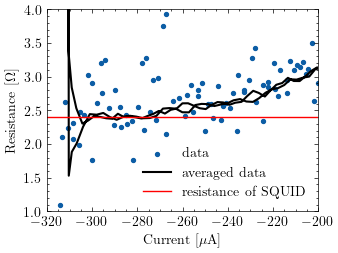

In [8]:
plt.scatter(liquid_nitrogen['0_x'], np.gradient(liquid_nitrogen['0_y'], liquid_nitrogen['0_x']), label='data',s=8)
w = 8
x,y = liquid_nitrogen['0_x'].rolling(window=w).mean(), liquid_nitrogen['0_y'].rolling(window=w).mean()
plt.plot(x, np.gradient(y, x), label='averaged data',lw=1.5,c='k')

plt.xlim(-320,-200)
plt.ylim(1,4)


resistance = un.ufloat(2.4,0.4)
normal_resistance = 2*resistance
plt.axhline(resistance.n, label='resistance of SQUID',c='r')

print(f"normal_resistance= {normal_resistance:L} Ohm")

critical_voltage = normal_resistance * critical_current
print(f"critical_voltage= {critical_voltage*1e3:L} mV")

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Resistance [$\Omega$]')
plt.legend()
plt.savefig('SQUID/output/2-resistance.pdf')

(-373.19587628865975+/-1.5264446888479353,
 444.74793814432985+/-1.2277405249506017)

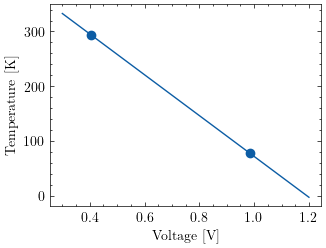

In [9]:
calibr_temp = [21.2+273.15, 77.15]
calibr_volts = [403*1e-3, 985*1e-3]

calibr_temp = unp.uarray(calibr_temp,[0.4,0.05])
calibr_volts = unp.uarray(calibr_volts,1.5e-3)

voltrange = np.linspace(300e-3, 1200e-3, 1000)

plt.scatter(unp.nominal_values(calibr_volts), unp.nominal_values(calibr_temp), label='calibration points')

m = (calibr_temp[1]-calibr_temp[0])/(calibr_volts[1]-calibr_volts[0])
b = calibr_temp[0] - m*calibr_volts[0]

plt.plot(voltrange, unp.nominal_values(m*voltrange + b), label='fit')

def temp(volt):
    return m*volt + b

plt.xlabel('Voltage [V]')
plt.ylabel('Temperature [K]')
plt.savefig('SQUID/output/2-diode-calibration.pdf')

m, b

## 2 Temperature dependency

### Load data

In [10]:
t1 = pd.read_csv('SQUID/data/tempdep_part1.csv')
t2 = pd.read_csv('SQUID/data/tempdep_part2.csv')
t3 = pd.read_csv('SQUID/data/tempdep_part3.csv')
t1

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y
0,122.303741,6.430333,120.774517,5.921169,120.774517,9.739900,120.009906,13.304050,121.539129,31.379379,120.519647,123.538102,122.558612,262.539933,121.539129,233.262990
1,124.597577,6.430333,123.068353,11.521975,122.048871,14.576960,122.303741,20.177767,123.323224,34.434365,122.813483,132.193894,124.852448,268.140739,122.558612,240.391289
2,126.891413,11.012811,125.617059,14.576960,125.617059,14.322378,124.597577,23.232752,125.617059,43.853903,125.617059,138.303864,127.146283,273.486963,126.126801,244.210021
3,129.949860,12.794886,128.420636,14.322378,127.146283,27.560648,127.656024,28.324394,128.675507,52.764276,128.675507,145.177581,129.694990,280.106098,127.910895,251.338320
4,131.988825,18.141110,130.714472,17.631946,130.714472,26.542319,129.949860,37.998514,131.224213,59.128829,130.714472,151.032970,132.498566,284.943158,130.714472,255.411634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,204.881825,238.609215,203.352601,240.645872,203.607472,252.611231,203.097731,259.484947,204.626955,278.833188,203.862343,332.295430,204.881825,450.676110,203.607472,406.633405
496,207.430532,246.755842,206.920790,247.265006,205.391567,258.212037,204.881825,267.122411,205.901308,284.179412,204.881825,339.423729,207.430532,456.531498,206.156178,412.488794
497,210.488979,253.884141,207.685402,255.157052,208.195143,266.613246,208.704885,273.232381,209.214626,292.071457,208.959755,344.515371,210.743850,462.641469,208.195143,416.816690
498,212.782815,261.521604,210.743850,261.776186,210.234108,273.996128,210.998720,280.615262,211.763332,297.926846,210.998720,350.370760,212.527944,468.242275,210.743850,423.944989


Text(0, 0.5, 'Temperature [K]')

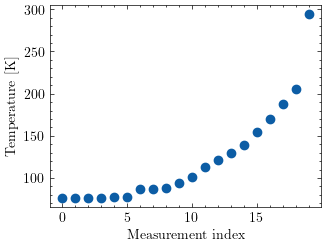

In [11]:
voltages = [986, 985.8, 986.6, 985.7, 985.2, 984.8, 958, 959.5, 957, 940, 920, 890, 867, 843, 820, 777, 736,690,642,0]
temps = temp(unp.uarray(voltages, 1.2)*1e-3)
temps[-1]= calibr_temp[0]
plt.scatter(range(len(temps)), unp.nominal_values(temps), label='measured temperatures')
plt.xlabel('Measurement index')
plt.ylabel('Temperature [K]')


### analysis

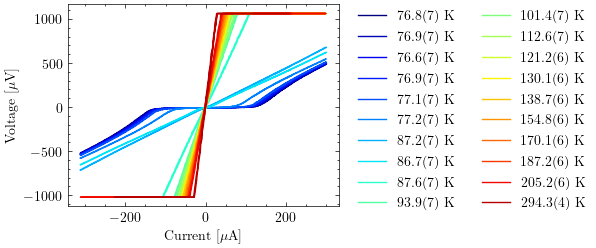

In [12]:
plots = 20
colors = mapcolors(plots)
# part 1
for i in range(8):
    plt.plot(t1[f'{i}_x'], t1[f'{i}_y'], label=f'{temps[i]:S} K', c= mapcolors(plots)[i])

# part 2
for i in range(8):
    plt.plot(t2[f'{i}_x'], t2[f'{i}_y'], label=f'{temps[i+8]:S} K', c= mapcolors(plots)[i+8])

for i in range(3):
    plt.plot(t3[f'{i}_x'], t3[f'{i}_y'], label=f'{temps[i+16]:S} K', c= mapcolors(plots)[i+16])

plt.plot(room_temp['0_x'], room_temp['0_y'], label=f'{calibr_temp[0]:S} K', c= mapcolors(plots)[-1])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)

i=7
# plt.plot(t1[f'{i}_x'], t1[f'{i}_y'], label=f'{temps[i]} K', c= 'k')

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

plt.savefig('SQUID/output/2-temperature-dependency.pdf')


In [13]:
def linfit(x, a, b):
    return a*x + b

# create empty unumpy arrays
resistances = unp.uarray(np.zeros(20), np.zeros(20))

87.6(7) K: 2.489(19) Ohm
93.9(7) K: 2.459(19) Ohm
101.4(7) K: 2.420(19) Ohm
112.6(7) K: 2.383(19) Ohm
121.2(6) K: 2.331(18) Ohm
130.1(6) K: 2.133(16) Ohm
138.7(6) K: 2.365(17) Ohm
154.8(6) K: 2.195(16) Ohm
normal resistance: 4.69(23) Ohm


Text(0, 0.5, 'Voltage [$\\mu$V]')

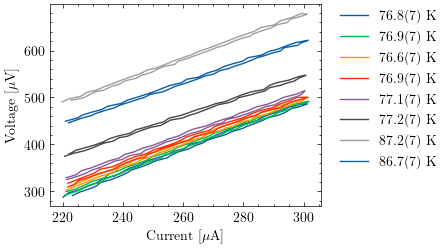

In [14]:
#part 1 alt
slopes = unp.uarray(np.zeros(8), np.zeros(8))
a,b = 40,100
for i in range(8):
    x,y = t1[f'{i}_x'][a:b], t1[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i]:S} K')
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    slopes[i] = resistance
    print(f'{temps[i+8]:S} K: {resistance:S} Ohm')

normal_slope = un.ufloat(np.mean(unp.nominal_values(slopes)), np.std(unp.nominal_values(slopes)))

print(f'normal resistance: {normal_slope*2:S} Ohm')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xlim(-10, 10)
# plt.ylim(-50, 50)

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

76.8(7)K 0.028(4)Ohm
76.9(7)K 0.037(4)Ohm
76.6(7)K 0.0421(33)Ohm
76.9(7)K 0.039(4)Ohm
77.1(7)K 0.051(6)Ohm
77.2(7)K 0.122(6)Ohm


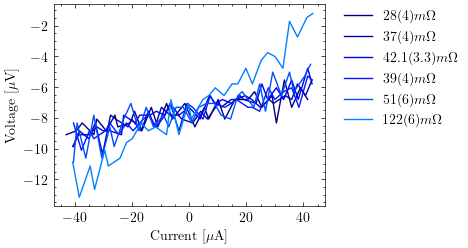

In [15]:
# part 1 neue

a,b = 165,198
for i in range(6):
    x,y = t1[f'{i}_x'][a:b] , t1[f'{i}_y'][a:b]
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    plt.plot(x, y, label=f'{resistance*1e3:S}$m\Omega$',c=colors[i])

    resistances[i] = 2*resistance
    print(f'{temps[i]:S}K {resistance:S}Ohm')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

plt.savefig('SQUID/output/2-low-temp-resistance.pdf')


87.2(7) K: 2.039(14) Ohm
86.7(7) K: 1.60(4) Ohm
87.6(7) K: 9.176(35) Ohm
93.9(7) K: 13.38(4) Ohm
101.4(7) K: 14.25(4) Ohm
112.6(7) K: 15.72(5) Ohm
121.2(6) K: 17.00(5) Ohm
130.1(6) K: 17.82(6) Ohm
138.7(6) K: 18.83(6) Ohm
154.8(6) K: 20.35(7) Ohm
170.1(6) K: 22.25(7) Ohm
187.2(6) K: 24.08(7) Ohm
205.2(6) K: 25.79(13) Ohm
294.3(4) K: 36.93(21) Ohm
U_crit= 0.33 \pm 0.10 mV


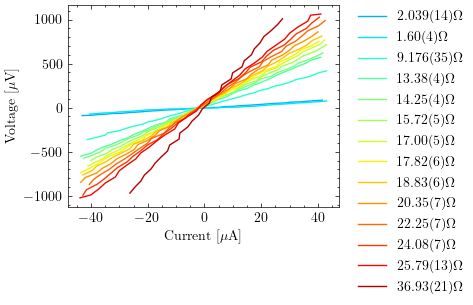

In [16]:
a,b = 165,198
# part 1 continued

# colors = mapcolors(len(temps)-6)
# print(len(colors))
for i in range(6,8):
    x,y = t1[f'{i}_x'][a:b] , t1[f'{i}_y'][a:b]
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    plt.plot(x, y, label=f'{resistance:S}$\Omega$', c= colors[i])

    resistances[i] = 2*resistance
    print(f'{temps[i]:S} K: {resistance:S} Ohm')


# part 2 + 3

for i in range(8):
    x,y = t2[f'{i}_x'][a:b] , t2[f'{i}_y'][a:b]
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    plt.plot(x, y, label=f'{resistance:S}$\Omega$', c= colors[i+8])

    resistances[i+8] = 2*resistance
    print(f'{temps[i+8]:S} K: {resistance:S} Ohm')

for i in range(3):
    x,y = t3[f'{i}_x'][a:b] , t3[f'{i}_y'][a:b]
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    plt.plot(x, y, label=f'{resistance:S}$\Omega$', c= colors[i+16])

    resistances[i+16] = 2*resistance
    print(f'{temps[i+16]:S} K: {resistance:S} Ohm')

a,b = 448,478
x,y = room_temp['0_x'][a:b] , room_temp['0_y'][a:b]
c, cov = curve_fit(linfit, x, y)
resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
plt.plot(x, y, label=f'{resistance:S}$\Omega$', c= colors[-1])

resistances[-1] = 2*resistance
print(f'{calibr_temp[0]:S} K: {resistance:S} Ohm')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

# normal_resistance = resistances[6]
# print(f"Normal resistance: {normal_resistance:S} Ohm measured at {temps[6]:S} K")


critical_voltage = critical_current * normal_resistance
print(f"U_crit= {critical_voltage*1e3:L} mV")

plt.savefig('SQUID/output/2-higher-temp-resistance.pdf')


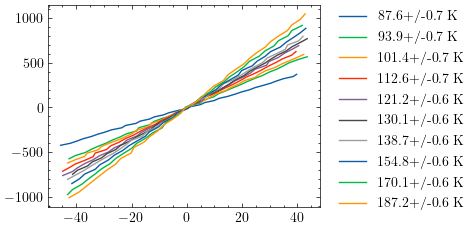

In [17]:
# part 2 + 3 second data interval
a,b = 398,432
for i in range(8):
    plt.plot(t2[f'{i}_x'][a:b], t2[f'{i}_y'][a:b], label=f'{temps[i+8]} K')

for i in range(2):
    plt.plot(t3[f'{i}_x'][a:b], t3[f'{i}_y'][a:b], label=f'{temps[i+16]} K')



plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [18]:

print(r"\begin{tabular}{l|l}")
print(r"Temperature & Resistance \\")
print(r"\hline")
for t, r in zip(temps, resistances):
    if r.n < 1:
        print(rf"\SI{{{np.round(t.n,2)} \pm {np.round(t.s,2)}}}{{\kelvin}} & \SI{{{np.round(r.n*1e3,1)} \pm {np.round(r.s*1e3,1)}}}{{\milli\ohm}} \\ \hline")
    else:
        print(rf"\SI{{{np.round(t.n,2)} \pm {np.round(t.s,2)}}}{{\kelvin}} & \SI{{{np.round(r.n,2)} \pm {np.round(r.s,2)}}}{{\ohm}} \\ \hline")
print(r"\end{tabular}")

\begin{tabular}{l|l}
Temperature & Resistance \\
\hline
\SI{76.78 \pm 0.72}{\kelvin} & \SI{55.6 \pm 8.8}{\milli\ohm} \\ \hline
\SI{76.85 \pm 0.72}{\kelvin} & \SI{74.6 \pm 7.5}{\milli\ohm} \\ \hline
\SI{76.55 \pm 0.72}{\kelvin} & \SI{84.2 \pm 6.5}{\milli\ohm} \\ \hline
\SI{76.89 \pm 0.72}{\kelvin} & \SI{77.3 \pm 8.0}{\milli\ohm} \\ \hline
\SI{77.08 \pm 0.72}{\kelvin} & \SI{102.6 \pm 12.3}{\milli\ohm} \\ \hline
\SI{77.22 \pm 0.72}{\kelvin} & \SI{243.1 \pm 11.3}{\milli\ohm} \\ \hline
\SI{87.23 \pm 0.7}{\kelvin} & \SI{4.08 \pm 0.03}{\ohm} \\ \hline
\SI{86.67 \pm 0.7}{\kelvin} & \SI{3.2 \pm 0.08}{\ohm} \\ \hline
\SI{87.6 \pm 0.7}{\kelvin} & \SI{18.35 \pm 0.07}{\ohm} \\ \hline
\SI{93.94 \pm 0.69}{\kelvin} & \SI{26.75 \pm 0.09}{\ohm} \\ \hline
\SI{101.41 \pm 0.68}{\kelvin} & \SI{28.51 \pm 0.09}{\ohm} \\ \hline
\SI{112.6 \pm 0.66}{\kelvin} & \SI{31.45 \pm 0.1}{\ohm} \\ \hline
\SI{121.19 \pm 0.65}{\kelvin} & \SI{34.01 \pm 0.11}{\ohm} \\ \hline
\SI{130.14 \pm 0.64}{\kelvin} & \SI{35.65 \pm 0.13}

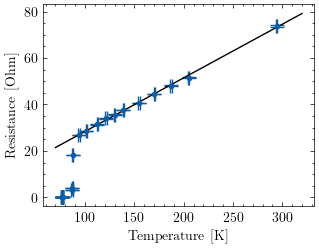

In [19]:
plt.errorbar(unp.nominal_values(temps), unp.nominal_values(resistances), xerr=unp.std_devs(temps), yerr=unp.std_devs(resistances), fmt='.',capsize=5, label='data')

xl = np.linspace(70,320)

x = unp.nominal_values(temps[9:])
y = unp.nominal_values(resistances[9:])
c, cov = curve_fit(linfit,x,y, )
param = unp.uarray(c, np.sqrt(np.diag(cov)))

plt.plot(xl,linfit(xl,*c),label=r"linear fit", c='k', lw=1)

plt.xlabel('Temperature [K]')
plt.ylabel('Resistance [Ohm]')


plt.savefig('SQUID/output/2-resistance-temperature.pdf')


last linear temperature: 93.9 \pm 0.7 K


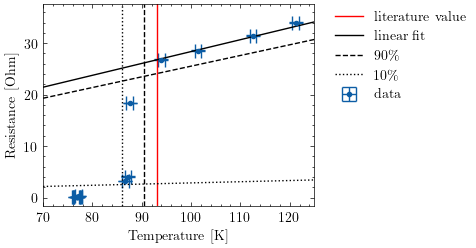

In [20]:
lim = 14
plt.errorbar(unp.nominal_values(temps[:lim]), unp.nominal_values(resistances[:lim]), xerr=unp.std_devs(temps)[:lim], yerr=unp.std_devs(resistances)[:lim], fmt='.',capsize=5, label='data')

plt.xlabel('Temperature [K]')
plt.ylabel('Resistance [Ohm]')

plt.xlim(70,125)
plt.axvline(x=93, c='r', label='literature value')

xl = np.linspace(70,125)

x = unp.nominal_values(temps[9:])
y = unp.nominal_values(resistances[9:])
c, cov = curve_fit(linfit,x,y, )
param = unp.uarray(c, np.sqrt(np.diag(cov)))

plt.plot(xl,linfit(xl,*c),label=r"linear fit", c='k', lw=1)

plt.plot(xl,linfit(xl,*c)*.9,label=r"90\%", c='k',ls='--',lw=1)
plt.axvline(x=90.5, c='k',ls='--',lw=1)

plt.plot(xl,linfit(xl,*c)*.1,label=r"10\%", c='k',ls=':',lw=1)
plt.axvline(x=86, c='k',ls=':',lw=1)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
# print(f"{temps[7]-1} K")
# plt.grid()

print(f"last linear temperature: {temps[9]:L} K")

plt.savefig('SQUID/output/2-resistance-temperature-zoom.pdf')


## 3 Flux dependency

### load data

In [21]:
flux1 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.07.29_Trace.csv',skiprows=1)
flux2 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.08.24_Trace.csv',skiprows=1)
flux3 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.44_Trace.csv',skiprows=1)
flux4 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.47_Trace.csv',skiprows=1)
flux5 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.50_Trace.csv',skiprows=1)
knee = pd.read_csv('SQUID/data/V-I/knee.csv')
increment= 0.0000002 * 1e6 # step size in us 
flux4, knee

(      Sequence   VOLT   VOLT.1  0.01652000  0.0000002000000
 0            0   15.2   0.0448         NaN              NaN
 1            1   15.2   0.0464         NaN              NaN
 2            2   14.8   0.0456         NaN              NaN
 3            3   15.2   0.0488         NaN              NaN
 4            4   14.8   0.0488         NaN              NaN
 ...        ...    ...      ...         ...              ...
 1195      1195   15.2   0.0144         NaN              NaN
 1196      1196   14.8   0.0128         NaN              NaN
 1197      1197   15.2   0.0080         NaN              NaN
 1198      1198   15.2   0.0064         NaN              NaN
 1199      1199   14.8   0.0040         NaN              NaN
 
 [1200 rows x 5 columns],
             0_x        0_y         1_x        1_y         2_x        2_y  \
 0    120.009906   9.230736  120.519647  13.049468  120.264776  11.012811   
 1    121.029388   6.939497  119.755035   3.884512  120.009906   1.847855   
 2    120

### analysis

In [22]:
def sinfit(x, Delta_U, U_0, phi_s, phi_0):
    return Delta_U*np.sin(2*np.pi*(x-phi_s)/phi_0) + U_0

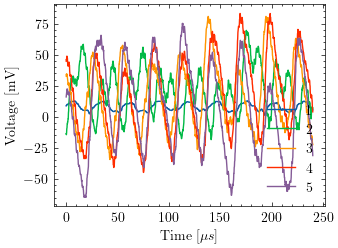

In [23]:
plt.plot(flux1['Sequence']*increment, flux1[' VOLT.1']*1e3, label='1')
plt.plot(flux2['Sequence']*increment, flux2[' VOLT.1']*1e3, label='2')
plt.plot(flux3['Sequence']*increment, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence']*increment, flux4[' VOLT.1']*1e3, label='4')
plt.plot(flux5['Sequence']*increment, flux5[' VOLT.1']*1e3, label='5')

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [mV]')

plt.legend()

[38.98569971  5.6712316   1.1731034   1.41592513] [0.44661492 0.32376526 0.0039604  0.00227612]
\Delta U = 78.0+/-0.9 uV
U_0 = 5.67+/-0.32 uV
\phi_s = 11.73+/-0.04 us
\phi_0 = 14.159+/-0.023 us
U(t) = 39.0(4) uV * sin(2\pi * (t - 11.73(4) us) / 14.159(23) us) + 5.67(32) uV
\(U(t) = \SI{39.0 \pm 0.4}{\micro\volt} \sin(2\pi \frac{ t - \SI{11.73 \pm 0.04}{\micro\second}}{ \SI{14.159 \pm 0.023}{\micro \second}}) + \SI{5.67 \pm 0.32}{\micro\volt}\)


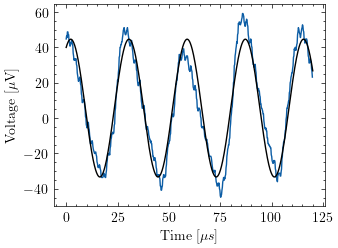

In [24]:
cut = 600

x = np.linspace(0, 6, 1000)
# plt.plot(flux1['Sequence'], flux1[' VOLT.1'], label='1')
# plt.plot(flux2['Sequence'], flux2[' VOLT.1'], label='2')
# plt.plot(flux3['Sequence']*1e-3, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT.1'][:cut]*1e3, label='data')
# plt.plot(flux5['Sequence']*1e-3, flux5[' VOLT.1']*1e3, label='5')

c, cov = curve_fit(sinfit, flux4['Sequence'][:cut]*1e-2, flux4[' VOLT.1'][:cut]*1e3)
perr=np.sqrt(np.diag(cov))
plt.plot(x*increment*1e2, sinfit(x, *c) , label='fit',c='k')
print(c, perr)
Delta_U = 2*un.ufloat(c[0],perr[0])*1e-6# in V
print(f"\Delta U = {Delta_U*1e6} uV")
print(f"U_0 = {un.ufloat(c[1],perr[1])} uV")
print(f"\phi_s = {un.ufloat(c[2],perr[2])*increment/2e-2} us")
phi_0 = un.ufloat(c[3],perr[3])*increment/2e-2 * 1e-6 # in s
print(f"\phi_0 = {phi_0*1e6} us")

print(f"U(t) = {Delta_U/2*1e6:S} uV * sin(2\pi * (t - {un.ufloat(c[2],perr[2])*increment/2e-2:S} us) / {phi_0*1e6:S} us) + {un.ufloat(c[1],perr[1]):S} uV")
print(rf"\(U(t) = \SI{{{Delta_U/2*1e6:L}}}{{\micro\volt}} \sin(2\pi \frac{{ t - \SI{{{un.ufloat(c[2],perr[2])*increment/2e-2:L}}}{{\micro\second}}}}{{ \SI{{{phi_0*1e6:L}}}{{\micro \second}}}}) + \SI{{{un.ufloat(c[1],perr[1]):L}}}{{\micro\volt}}\)")

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [$\mu$V]')

# plt.legend()

plt.savefig('SQUID/output/3-flux-oscillation.pdf')


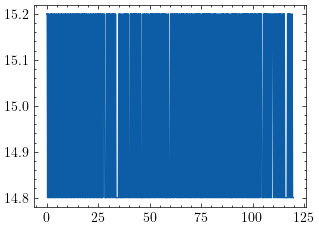

In [25]:
# plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT.1'][:cut], label='4')
cut = 600
plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT'][:cut], label='4')
# plt.plot(flux4[' VOLT'][:cut]*increment, flux4[' VOLT.1'][:cut], label='4')

/home/emil/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 50.0)

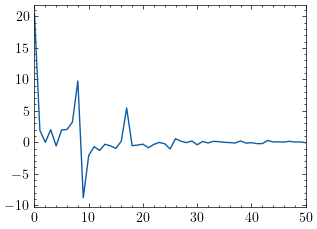

In [26]:
#fourier transform of the signal from flux4
plt.plot(np.fft.fft(flux4[' VOLT.1']))
plt.xlim(0,50)

# find peaks 

/home/emil/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/emil/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/emil/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1247: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/emil/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)


Text(0, 0.5, 'Resistance [$\\Omega$]')

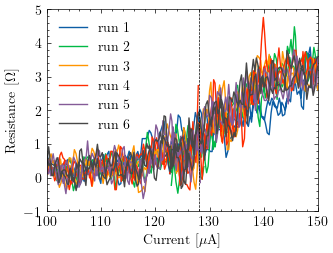

In [27]:
w= 18

for i in range(6):
    x ,y= knee[f'{i}_x'].rolling(window=w).mean(), knee[f'{i}_y'].rolling(window=w).mean()
    plt.plot(x, np.gradient(y,x), label=f'run {i+1}')
plt.xlim(100,150)
plt.ylim(-1,5)
plt.axvline(x=128, c='k', ls='--',lw=0.5)

plt.legend()
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Resistance [$\Omega$]')

Text(0, 0.5, 'Voltage [$\\mu$V]')

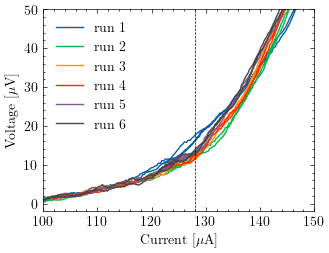

In [28]:
w= 15

for i in range(6):
    plt.plot(knee[f'{i}_x'].rolling(window=w).mean(), knee[f'{i}_y'].rolling(window=w).mean(), label=f'run {i+1}')
plt.xlim(100,150)
plt.ylim(-2,50)
plt.axvline(x=128, c='k', ls='--',lw=0.5)

plt.legend()
plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')


\Delta U = 7.0 \pm 3.0 uV


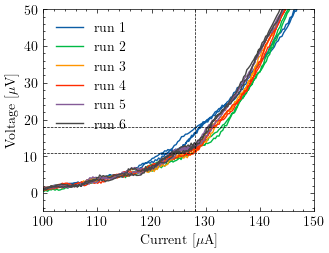

In [29]:
w= 12

for i in range(6):
    plt.plot(knee[f'{i}_x'].rolling(window=w).mean(), knee[f'{i}_y'].rolling(window=w).mean(), label=f'run {i+1}')

plt.xlim(100,150)
plt.ylim(-5,50)

u_min, u_max = 11,18


plt.axvline(x=128, c='k', ls='--',lw=0.5)
plt.axhline(y=u_max, c='k', ls='--',lw=0.5)
plt.axhline(y=u_min, c='k', ls='--',lw=0.5)


plt.legend()
Delta_U_smooth_knee = un.ufloat(u_max - u_min,3)*1e-6 # in V
print(f"\Delta U = {Delta_U_smooth_knee*1e6:L} uV")

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

plt.savefig('SQUID/output/4-knee-smoothed.pdf')

\Delta U = 15.7 \pm 3.0 uV


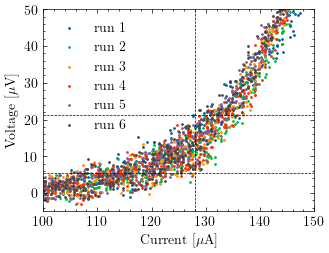

In [30]:
for i in range(6):
    plt.scatter(knee[f'{i}_x'], knee[f'{i}_y'], label=f'run {i+1}', s=1)
plt.xlim(100,150)
plt.ylim(-5,50)

u_min, u_max = 5.5, 21.2


plt.axvline(x=128, c='k', ls='--',lw=0.5)
plt.axhline(y=u_max, c='k', ls='--',lw=0.5)
plt.axhline(y=u_min, c='k', ls='--',lw=0.5)

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')
plt.legend()
Delta_U_knee = un.ufloat(u_max - u_min,3)*1e-6 # in V
print(f"\Delta U = {Delta_U_knee*1e6:L} uV")
plt.savefig('SQUID/output/4-knee.pdf')

Text(0, 0.5, 'Voltage [$\\mu$V]')

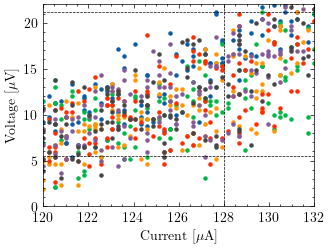

In [31]:
for i in range(6):
    plt.scatter(knee[f'{i}_x'], knee[f'{i}_y'], label=f'{i}', s=5)
plt.xlim(120,132)
plt.ylim(0,22)

plt.axvline(x=128, c='k', ls='--',lw=0.5)
plt.axhline(y=u_max, c='k', ls='--',lw=0.5)
plt.axhline(y=u_min, c='k', ls='--',lw=0.5)

plt.xlabel('Current [$\mu$A]')
plt.ylabel('Voltage [$\mu$V]')

#### $\beta_L$ calculation

In [32]:
induction = 73e-12
print(f"induction = {induction*1e12} pH")
print(f"Crit. current = {critical_current*1e6:L} uA")
print(f"Normal resistance = {normal_resistance:L} Ohm")
print(f"Delta U = {Delta_U*1e6:L} uV")
print(f"Delta U(knee) = {Delta_U_knee*1e6:L} uV")
print(f"Delta U(knee_smoothed) = {Delta_U_smooth_knee*1e6:L} uV")
print(f"Delta U/Delta U(knee) = {Delta_U/Delta_U_knee}")
print(f"Delta U/Delta U(knee_smoothed) = {Delta_U/Delta_U_smooth_knee}")
print(f"phi_0 = {phi_0} 1/H")
print(f"T = {calibr_temp[1]:L} K")
print(f"k_B = {con.k} J/K")

phi_0 = con.h/(2*con.elementary_charge)
beta_L1 = 2*critical_current*induction/phi_0
print(f"beta_L1 = {beta_L1:L}")

beta_L2 = 4* critical_current*normal_resistance/(np.pi * Delta_U) -1
print(f"beta_L2 = {beta_L2:L}")

beta_L3 = 4* critical_current*normal_resistance/(np.pi * Delta_U) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
print(f"beta_L3 = {beta_L3:L}")

beta_L2_knee = 4* critical_current*normal_resistance/(np.pi * Delta_U_knee) -1
print(f"beta_L2(knee) = {beta_L2_knee:L}")

beta_L3_knee = 4* critical_current*normal_resistance/(np.pi * Delta_U_knee) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
print(f"beta_L3(knee) = {beta_L3_knee:L}")

beta_L2_smooth_knee = 4* critical_current*normal_resistance/(np.pi * Delta_U_smooth_knee) -1
print(f"beta_L2(smooth_knee) = {beta_L2_smooth_knee:L}")

beta_L3_smooth_knee = 4* critical_current*normal_resistance/(np.pi * Delta_U_smooth_knee) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
print(f"beta_L3(smooth_knee) = {beta_L3_smooth_knee:L}")

beta_L2_frac = 4* critical_current*normal_resistance/(np.pi * Delta_U/2) -1
print(f"beta_L2 frac = {beta_L2_frac:L}")

beta_L3_frac = 4* critical_current*normal_resistance/(np.pi * Delta_U/2) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
print(f"beta_L3 frac = {beta_L3_frac:L}")

induction = 73.0 pH
Crit. current = 69 \pm 18 uA
Normal resistance = 4.8 \pm 0.8 Ohm
Delta U = 78.0 \pm 0.9 uV
Delta U(knee) = 15.7 \pm 3.0 uV
Delta U(knee_smoothed) = 7.0 \pm 3.0 uV
Delta U/Delta U(knee) = 5.0+/-1.0
Delta U/Delta U(knee_smoothed) = 11+/-5
phi_0 = (1.4159+/-0.0023)e-05 1/H
T = 77.15 \pm 0.05 K
k_B = 1.380649e-23 J/K
beta_L1 = 4.9 \pm 1.2
beta_L2 = 4.4 \pm 1.7
beta_L3 = 1.8 \pm 0.9
beta_L2(knee) = 26 \pm 10
beta_L3(knee) = 13 \pm 5
beta_L2(smooth_knee) = 59 \pm 32
beta_L3(smooth_knee) = 30 \pm 16
beta_L2 frac = 9.9 \pm 3.3
beta_L3 frac = 4.6 \pm 1.7


## 4 Flux quantum

### load data

In [33]:
steps=pd.read_csv('SQUID/data/mw-ind-steps.csv')
steps

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y
0,122.303741,152.560462,121.539129,182.091987,120.009906,217.733482,121.539129,100.625713,121.794000,9.994482
1,124.087836,157.906687,124.852448,188.201957,123.578094,223.588870,123.832965,109.026922,124.852448,4.648258
2,127.146283,160.961672,127.146283,188.201957,125.362189,228.171348,126.891413,111.572743,127.401154,13.813214
3,129.440119,164.271239,130.204731,195.584839,127.910895,233.772155,129.440119,119.210206,129.185248,10.758229
4,131.988825,167.835389,132.243696,198.385242,131.479084,238.100050,131.988825,124.301849,132.753437,19.668602
...,...,...,...,...,...,...,...,...,...,...
495,204.626955,271.195724,205.136696,302.509324,203.607472,335.604998,205.136696,258.212037,204.372084,237.081722
496,207.430532,270.941142,206.411049,308.619294,206.156178,335.859580,207.175661,260.757858,207.685402,245.482932
497,209.214626,276.287367,209.724367,312.692608,207.940273,340.951222,209.724367,265.594918,209.214626,252.865813
498,212.782815,276.796531,212.273074,318.038832,211.253591,342.733297,213.037685,270.177396,212.527944,258.721201


### analysis

steps_lit = 9.09846893323249e-05


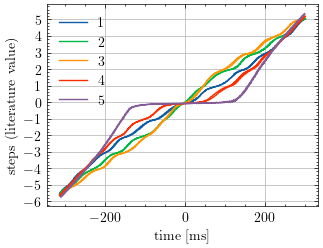

In [34]:
steps_lit = con.h/(2*con.elementary_charge) * 44e9
print(f"steps_lit = {steps_lit}")
plt.plot(steps['0_x'], steps['0_y']*1e-6/steps_lit, label='1')
plt.plot(steps['1_x'], steps['1_y']*1e-6/steps_lit, label='2')
plt.plot(steps['2_x'], steps['2_y']*1e-6/steps_lit, label='3')
plt.plot(steps['3_x'], steps['3_y']*1e-6/steps_lit, label='4')
plt.plot(steps['4_x'], steps['4_y']*1e-6/steps_lit, label='5')

plt.legend()
plt.xlabel('time [ms]')
plt.ylabel('steps (literature value)')

plt.yticks(np.arange(-6, 6, step=1))

plt.grid()



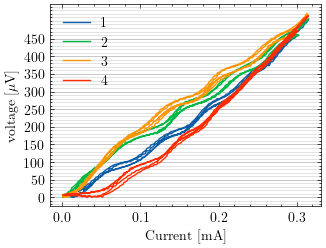

In [35]:
plt.plot(np.abs(steps['0_x'])*1e-3, np.abs(steps['0_y']), label='1',lw=1)
plt.plot(np.abs(steps['1_x'])*1e-3, np.abs(steps['1_y']), label='2',lw=1)
plt.plot(np.abs(steps['2_x'])*1e-3, np.abs(steps['2_y']), label='3',lw=1)
plt.plot(np.abs(steps['3_x'])*1e-3, np.abs(steps['3_y']), label='4',lw=1)
# plt.plot(np.abs(steps['4_x'])*1e-3, np.abs(steps['4_y']), label='5',lw=1)

plt.legend()
plt.xlabel('Current [mA]')
plt.ylabel('voltage [$\mu$V]')

# print(steps_lit*1e9)
plt.yticks(np.arange(0,500,step=50))

plt.grid(which='major', axis='y')
plt.grid(which='minor', alpha=0.5, axis='y')
plt.minorticks_on()

plt.savefig('SQUID/output/4-shapiro-steps.pdf')

# plt.yticks(np.arange(0,500,step=1e6*steps_lit))

# plt.savefig('SQUID/output/shapiro-steps-theo.pdf')


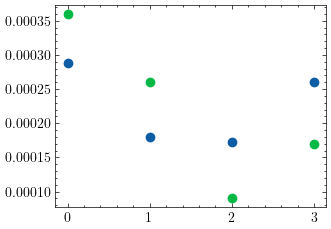

In [36]:
v1 = unp.uarray([0.000288,	0.00018,	0.000173,	0.00026],0.00001)
v2 = unp.uarray([0.00036,	0.00026,	0.000091,	0.00017],0.00001)
shapiro_steps = np.abs(v1-v2)
plt.scatter(range(len(v1)), unp.nominal_values(v1), label='1')
plt.scatter(range(len(v2)), unp.nominal_values(v2), label='2')

# plt.scatter(range(len(shapiro_steps)), unp.nominal_values(shapiro_steps), label='1')

In [37]:
n_step,u_step = 0,0

print(r"\begin{tabular}{c|c}")
print(r"step & voltage \\ \hline")
for i,s in enumerate(shapiro_steps):
    n_step += unp.nominal_values(s)
    u_step += unp.std_devs(s)**2
    print(rf"{i+1} & \SI{{{s*1e6:L}}}{{\micro\volt}} \\ \hline")
print(r"\end{tabular}")

shapiro_step = un.ufloat(n_step/len(shapiro_steps),np.sqrt(u_step))
print(f"shapiro_step = {shapiro_step*1e6:L} uV")
print(f"h/e = {shapiro_step/44e9*2:L}")
print(f"h/e lit = {con.h/(con.elementary_charge)}")

\begin{tabular}{c|c}
step & voltage \\ \hline
1 & \SI{72 \pm 14}{\micro\volt} \\ \hline
2 & \SI{80 \pm 14}{\micro\volt} \\ \hline
3 & \SI{82 \pm 14}{\micro\volt} \\ \hline
4 & \SI{90 \pm 14}{\micro\volt} \\ \hline
\end{tabular}
shapiro_step = 81 \pm 28 uV
h/e = \left(3.7 \pm 1.3\right) \times 10^{-15}
h/e lit = 4.135667696923859e-15
